In [ ]:
!pip install easyocr

In [ ]:
!pip install -q keras-ocr

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
import os
import math

from transformers import pipeline
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import torch

import easyocr
import keras_ocr

# Read and Label Image Dataset

In [ ]:
def load_images_from_folder(folder):
    images = []
    names = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            names.append(filename)
    return images, names

In [ ]:
def load_images_from_folder_with_order(folder, filenames):
    images = []
    names = []
    for filename in filenames:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            names.append(filename)
    return images, names

In [ ]:
def load_text_from_file(file):
  lines = []

  with open(file) as file:
      for line in file:
          line = line.strip()
          lines.append(line)

  return lines

In [ ]:
car_clear_order = load_text_from_file("/content/drive/MyDrive/cs415/project/car_clear_order.txt")
car_unclear_order = load_text_from_file("/content/drive/MyDrive/cs415/project/car_unclear_order.txt")
house_clear_order = load_text_from_file("/content/drive/MyDrive/cs415/project/house_clear_order.txt")
house_unclear_order = load_text_from_file("/content/drive/MyDrive/cs415/project/house_unclear_order.txt")

In [ ]:
car_clear_images, car_clear_names = load_images_from_folder_with_order("/content/drive/MyDrive/cs415/project/car clear", car_clear_order)
car_unclear_images, car_unclear_names = load_images_from_folder_with_order("/content/drive/MyDrive/cs415/project/car unclear", car_unclear_order)
house_clear_images, house_clear_names = load_images_from_folder_with_order("/content/drive/MyDrive/cs415/project/house clear", house_clear_order)
house_unclear_images, house_unclear_names = load_images_from_folder_with_order("/content/drive/MyDrive/cs415/project/house unclear", house_unclear_order)

both, both_names = load_images_from_folder("/content/drive/MyDrive/cs415/project")

Check number of images

In [ ]:
print("clear car: ", len(car_clear_images))
print("unclear car: ", len(car_unclear_images))
print("clear house: ", len(house_clear_images))
print("unclear house: ", len(house_unclear_images))
print("both: ", len(both))

print("total images: ", (len(car_clear_images) + len(car_unclear_images) + len(house_clear_images) + len(house_unclear_images) + len(both)))

clear car:  17
unclear car:  23
clear house:  25
unclear house:  25
both:  1
total images:  91


Parse text labels

In [ ]:
text = load_text_from_file("/content/drive/MyDrive/cs415/project/text_labels.txt")

In [ ]:
def label_image(image_arr, name_arr, obj, clarity):
  labeled = []

  for i in range(0, len(image_arr)):
      dict = {
          "obj": obj,
          "clarity": clarity,
          "img": image_arr[i],
          "filename": name_arr[i],
          "text": "null"
      }

      labeled.append(dict)

  return labeled

In [ ]:
car_clear_labeled = label_image(car_clear_images, car_clear_names, "car", "clear")
car_unclear_labeled = label_image(car_unclear_images, car_unclear_names, "car", "unclear")
house_clear_labeled = label_image(house_clear_images, house_clear_names, "house", "clear")
house_unclear_labeled = label_image(house_unclear_images, house_unclear_names, "house", "unclear")

both_labeled = label_image(both, both_names, "both", "unclear")

In [ ]:
images_labeled = []
images_labeled = car_clear_labeled + car_unclear_labeled + house_clear_labeled + house_unclear_labeled + both_labeled


images = []
images = car_clear_images + car_unclear_images + house_clear_images + house_unclear_images + both

In [ ]:
i = 0

for line in text:
    images_labeled[i]["text"] = line
    i = i + 1

# Object Detection

Use object detection to determine number source as either car or non-car (house)

### Determine source with OWL-ViT

In [ ]:
checkpoint = "google/owlvit-base-patch32"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
def check_for_objects(image_index):
    predictions = detector(
        images_array[image_index],
        candidate_labels=text_queries,
    )

    return predictions

In [ ]:
images_array = []

for i in range(0, len(images)):
    images_array.append(Image.fromarray(np.uint8(images[i])).convert("RGB"))

In [ ]:
false_positives = []
false_negatives = []

cars = []
no_cars = []

car_bounds= []

text_queries = ["car", "vehicle", "automobile"]
for i in range(0, len(images_array)):
    results = check_for_objects(i)
    #print(results)

    if(len(results) == 0):
        if(images_labeled[i]["obj"] == "car"):
            print(images_labeled[i]["obj"] + " " + images_labeled[i]["clarity"] + " image " + str(i) + " falsely detected no cars")
            false_negatives.append(i)
        else:
            print("no cars here in " + images_labeled[i]["obj"] + " " + images_labeled[i]["clarity"] + " image")
            no_cars.append(i)
    else:
        score = str(results[0]["score"])

        if(images_labeled[i]["obj"] == "car"):
            print(images_labeled[i]["obj"] + " " + images_labeled[i]["clarity"] +" image " + str(i) + " is correct with a score of " + score)
            cars.append(i)
            car_bounds.append(results[0]["box"])
        else:
            print(images_labeled[i]["obj"] + " " + images_labeled[i]["clarity"] +" image " + str(i) + " is false with a score of " + score)
            false_positives.append(i)

In [ ]:
print(false_negatives)
print(false_positives)

#print(cars)
#print(no_cars)

print(str(len(false_negatives) + len(false_positives)) + " out of 91 were incorrect")

[2, 20, 22, 33]
[]
4 out of 91 were incorrect


Record how each image was detected

In [ ]:
# Cars that were detected as cars
for index in cars:
  images_labeled[index]["obj_correct"] = "yes"

In [ ]:
# Cars that were NOT detected as cars
for index in false_negatives:
  images_labeled[index]["obj_correct"] = "no"

In [ ]:
# Non-Cars that were not detected as cars
for index in no_cars:
  images_labeled[index]["obj_correct"] = "yes"

In [ ]:
# Non-Cars that WERE detected as cars
for index in false_positives:
  images_labeled[index]["obj_correct"] = "no"

### Crop to text

Either use OWL-ViT to extract license plates or keras-OCR to extract text boxes.
Once a text crop has been found, save it to list.

In [ ]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

In [ ]:
def mask_bbox_extents(bounds_list, index_list):

  masks = []

  for i in range(0, len(bounds_list)):
      box = bounds_list[i]
      image = images[index_list[i]]

      x0, y0 = box["xmin"], box["ymin"]
      x1, y1 = box["xmax"], box["ymin"]
      x2, y2 = box["xmax"], box["ymax"]
      x3, y3 = box["xmin"], box["ymax"]

      x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
      x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
      thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

      mask = np.zeros(image.shape[:2], dtype="uint8")
      cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255, thickness)

      masked = cv2.bitwise_and(image, image, mask=mask)

      masks.append(masked)

  return masks;

In [ ]:
def mask_bbox_corners(bounds_list, index_list):
  masks = []

  for i in range(0, len(bounds_list)):

    item = bounds_list[i]
    box = item[0][1]

    image = images[index_list[i]]

    x0, y0 = box[0]
    x1, y1 = box[1]
    x2, y2 = box[2]
    x3, y3 = box[3]

    x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
    x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
    thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255, thickness)

    masked = cv2.bitwise_and(image, image, mask=mask)

    masks.append(masked)

    return masks;

In [ ]:
# invert = 0 -> crop black rows/columns
# invert = 1 -> crop white rows/colums

def cropImg(full_img, invert):
  # convert image to grayscale
  img = cv2.cvtColor(full_img, cv2.COLOR_BGR2GRAY)

  # sum each row and each vcolumn of the image
  sumOfCols = np.sum(img, axis=0)
  sumOfRows = np.sum(img, axis=1)

  # find first column that isn't all black/white
  for i in range(len(sumOfCols)):
    if sumOfCols[i] > 0:
      x1 = i
      break

  # find last column that isn't all black/white
  for i in reversed(range(0,len(sumOfCols))):
    if sumOfCols[i] > 0:
      x2 = i
      break

  # find first row that isn't all black/white
  for i in range(len(sumOfRows)):
    if sumOfRows[i] > 0:
      y1 = i
      break

  # find last row that isn't all black/white
  for i in reversed(range(0,len(sumOfRows))):
    if sumOfRows[i] > 0:
      y2 = i
      break

  # get slice from source img
  return full_img[y1:y2,x1:x2]

In [ ]:
def is_numbers(inputString):
    return any(char.isdigit() for char in inputString)

In [ ]:
# Car Plates using OWL-ViT
text_queries = ["plate", "license plate", "car plate"]
plate_bounds = []
plate_inds = []

for i in range(0, len(images)):
    results = check_for_objects(i)
    #print(results)

    if(len(results) > 0):
        plate_inds.append(i) #indices of images and images_labeled where plate was detected
        plate_bounds.append(results[0]["box"])

In [ ]:
plate_masks = mask_bbox_extents(plate_bounds, plate_inds)

In [ ]:
plate_masks_cropped = []

for plate in plate_masks:
  plate_masks_cropped.append(cropImg(plate, 0))

`plate_masks_cropped` contains all of the cropped plate images, and `plate_ind` contains indexes in `images_labeled` to associate the palte with its text label

In [ ]:
 # House Numbers using Keras-OCR
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
no_cars = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
house_predictions = []
house_inds = []

for index in no_cars:
  image = images[index]

  img = keras_ocr.tools.read(image)

  # Prediction_groups is a list of (word, box) tuples
  prediction_groups = pipeline.recognize([img])

  #print image with annotation and boxes
  #keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[0])

  number_boxes = []

  #only save numbers
  for prediction in prediction_groups:
      for item in prediction:
          if(is_numbers(item[0])):
              number_boxes.append(item)

  house_predictions.append(number_boxes)
  house_inds.append(index)

1/1 [==============================] - 0s 431ms/step


In [ ]:
house_bounds = []
house_inds_correct = []

detected_count = 0
i = 0

print(str(len(house_predictions)) + " house numbers cropped")

for prediction in house_predictions:

  if(len(prediction) > 0):
    detected = prediction
    detected_text = detected[0][0]

    house_bounds.append(prediction)
    house_inds_correct.append(house_inds[i])

    detected_count = detected_count + 1

  else:
    detected_text = "NONE"

  print(str(i) + ": " + images_labeled[house_inds[i]]["obj"] + " says " + images_labeled[house_inds[i]]["text"] + " and, from detection, " + detected_text)
  i = i + 1

print(detected_count)

50 house numbers cropped
0: house says 60 and, from detection, 60
1: house says 125 and, from detection, 125
2: house says 145 and, from detection, 145
3: house says 785 and, from detection, 785
4: house says 212 and, from detection, NONE
5: house says 180 and, from detection, 180
6: house says 188 and, from detection, 188
7: house says 2509 and, from detection, 7500
8: house says 2515 and, from detection, 2515
9: house says 2507 and, from detection, 2507
10: house says null and, from detection, NONE
11: house says 2511 and, from detection, NONE
12: house says 2517 and, from detection, 2517
13: house says 2521 and, from detection, 2521
14: house says 2501 03 and, from detection, 0so
15: house says 627 and, from detection, 627
16: house says 817 and, from detection, 817
17: house says 57 and, from detection, 57
18: house says 2640 and, from detection, 2640
19: house says 131 and, from detection, b1
20: house says 169 and, from detection, 169
21: house says 75 and, from detection, 6
22: 

In [ ]:
masks = []
i = 0

for house in house_bounds:

    box = house[0][1]
    image = images[house_inds_correct[i]]

    x0, y0 = box[0]
    x1, y1 = box[1]
    x2, y2 = box[2]
    x3, y3 = box[3]

    x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
    x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
    thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255, thickness)

    masked = cv2.bitwise_and(image, image, mask=mask)

    masks.append(masked)

    i = i + 1

In [ ]:
house_masks_cropped = []

for house in masks:
  house_masks_cropped.append(cropImg(house, 0))

Finalize `text_patches` list

In [ ]:
text_patches = plate_masks_cropped + house_masks_cropped
text_patches_inds = plate_inds + house_inds_correct

2501 03


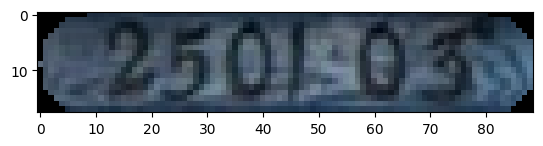

In [ ]:
index = 45
print(images_labeled[text_patches_inds[index]]["text"])

plt.imshow(text_patches[index])

# Proprocessing for Optical Character Recognition

In [ ]:
def noise_removal(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)

    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)

    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

In [ ]:
def rotate_image(image, angle):
    if(angle == "no lines found"):
      return "no lines found"

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def compute_skew(src_img):

    if len(src_img.shape) == 3:
        h, w, _ = src_img.shape
    elif len(src_img.shape) == 2:
        h, w = src_img.shape
    else:
        print('unsupported image type')

    img = cv2.medianBlur(src_img, 3)

    edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
    lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 4.0, maxLineGap=h/4.0)
    angle = 0.0

    if lines is None:
      return "no lines found"

    nlines = lines.size

    #print(nlines)
    cnt = 0
    for x1, y1, x2, y2 in lines[0]:
        ang = np.arctan2(y2 - y1, x2 - x1)
        #print(ang)
        if math.fabs(ang) <= 30: #excluding extreme rotations
            angle += ang
            cnt += 1

    if cnt == 0:
        return 0.0
    return (angle / cnt)*180/math.pi

def deskew(src_img):
    rotate = rotate_image(src_img, compute_skew(src_img))

    if(rotate == "no lines found"):
      return 0
    else:
      return rotate


In [ ]:
  def plot_hist(plot, number_bins, title):
    # plot the histogram
    plt.figure()
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("% of Pixels")
    plt.plot(plot)
    plt.xlim([0, number_bins])
    plt.show()

In [ ]:
def show(img):
  plt.imshow(img)

Example Processing and OCR pipeline on sample image

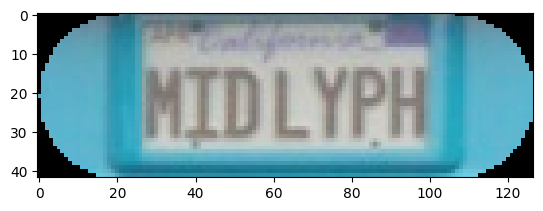

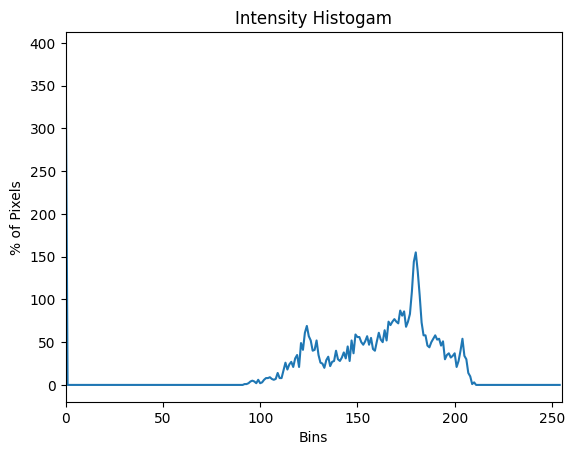

In [ ]:
image = text_patches[7]

show(image)

big = cv2.resize(image, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
gray = cv2.cvtColor(big, cv2.COLOR_BGR2GRAY)

hist = cv2.calcHist([image], [1], None, [255], [0, 256])
plot_hist(hist, 255, "Intensity Histogam")

Visually examine histogram to decide which type of thresholding. If it looks mostly bimodal, we'll use OTSU. If not, Adaptive Gaussian

In [ ]:
isBimodal = False

In [ ]:
# Determine if bimodal enough for OTSU
if(isBimodal):
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
else:
  thresh2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,65,3)

  thresh = noise_removal(thresh2)

<ipython-input-45-52043eab8e53>:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(rotate == "no lines found"):


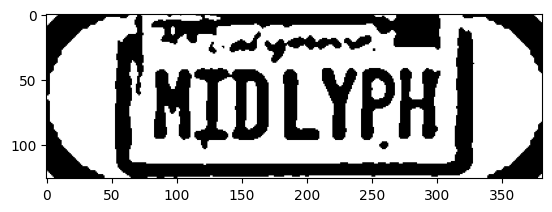

In [ ]:
corrected = deskew(thresh)

if(corrected.any() == 0):
  final = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
else:
  final = cv2.cvtColor(corrected, cv2.COLOR_GRAY2RGB)

plt.imshow(final)


In [ ]:
forOCR = cropImg(final, 1)

In [ ]:
result = reader.readtext(final)

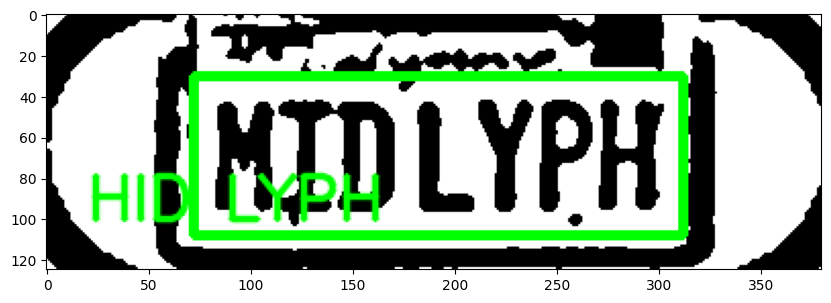

In [ ]:
img = forOCR

top_left = tuple(result[0][0][0])
bottom_right = tuple(result[0][0][2])
text = result[0][1]
font = cv2.FONT_HERSHEY_SIMPLEX
spacer = 100
for detection in result:
    top_left = tuple(detection[0][0])
    bottom_right = tuple(detection[0][2])
    text = detection[1]
    img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
    #Change boldness and font size and spacing here
    img = cv2.putText(img,text,(20,spacer), font, 1,(0,255,0),2,cv2.LINE_AA)
    spacer+=100
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

Process all patches

In [ ]:
def process_for_OCR(patch, isBimodal):

  image = patch

  # Upscale and Grayscale
  big = cv2.resize(image, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
  gray = cv2.cvtColor(big, cv2.COLOR_BGR2GRAY)

  # Determine if bimodal enough for OTSU, perform thresholding
  if(isBimodal):
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
  else:
    thresh2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
              cv2.THRESH_BINARY,25,2)
    thresh = noise_removal(thresh2)

  forOCR = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

  return forOCR

In [ ]:
def checkHist(patch):
    hist = cv2.calcHist([image], [1], None, [255], [0, 256])
    plot_hist(hist, 255, "Intensity Histogam")

In [ ]:
processed_patches = []
for patch in text_patches:
  processed_patches.append(process_for_OCR(patch, True))

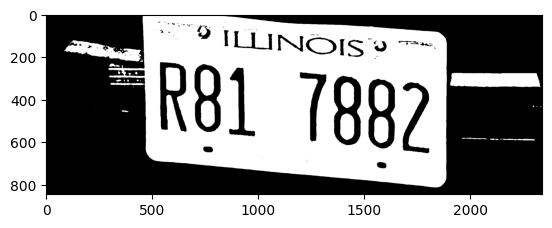

In [ ]:
show(processed_patches[20])

# Perform final OCR on all processed patches

In [ ]:
reader = easyocr.Reader(['en'])

Sample output

In [ ]:
result = reader.readtext(images[90])

In [ ]:
forOCR = images[90]

# loop over the results
for (bbox, text, prob) in result:
	# display the OCR'd text and associated probability

	# unpack the bounding box
	(tl, tr, br, bl) = bbox
	tl = (int(tl[0]), int(tl[1]))
	tr = (int(tr[0]), int(tr[1]))
	br = (int(br[0]), int(br[1]))
	bl = (int(bl[0]), int(bl[1]))
	# cleanup the text and draw the box surrounding the text along
	# with the OCR'd text itself
	cv2.rectangle(forOCR, tl, br, (0, 255, 0), 2)
	cv2.putText(forOCR, text, (tl[0], tl[1] - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# show the output image
plt.figure(figsize = [20, 20])
plt.imshow(forOCR)

In [ ]:
results = []
for patch in processed_patches:
  results.append(reader.readtext(patch))

In [ ]:
for i in range(0, len(processed_patches)):
  for (bbox, text, prob) in results[i]:
    # display the OCR'd text and associated probability
    # unpack the bounding box
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))

    # cleanup the text and draw the box surrounding the text along
    # with the OCR'd text itself
    cv2.rectangle(processed_patches[i], tl, br, (0, 255, 0), 2)
    cv2.putText(processed_patches[i], text, (tl[0], tl[1] - 10),
      cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

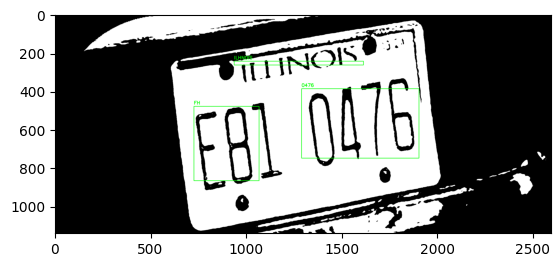

In [ ]:
show(processed_patches[1])

First Pass results

car unclear both_unclear.png CZ 28451


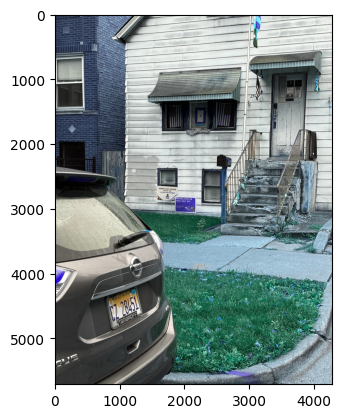

In [ ]:
index = 90

print(images_labeled[index]["obj"], images_labeled[index]["clarity"], images_labeled[index]["filename"], images_labeled[index]["text"])
show(images[index])

In [ ]:
show(processed_patches[19])

In [ ]:
i = 0
for index in text_patches_inds:
  source = images_labeled[index]["text"]
  result = []

  for (bbox, text, prob) in results[i]:
    result.append(text)

  print(str(i) + ": Image " + str(index) + " " + images_labeled[index]["obj"] + images_labeled[index]["clarity"] + " has " + str(len(source)) + ": " + source + " and detected " + str(result))

  i = i + 1